## Feed forward neural network

In [1]:
from data_processing import process_dataframe

In [2]:
import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")  # specify to ignore warning messages

In [3]:
SEED = 42

### Load dataset

In [9]:
# Load in data to a pandas dataframe
df = pd.read_pickle('/Users/lb962/Documents/GitHub/ArcticTurbulence/data/ml_ready/merged_arctic.pkl')
df.reset_index(drop=True, inplace=True)

# Exploration
The data is quite imbalanced and has two peaks and is heavily imbalanced towards the lower values. Deal with class imbalance by a transformation towards a Gaussian, weighted loss or doing stratified binning.

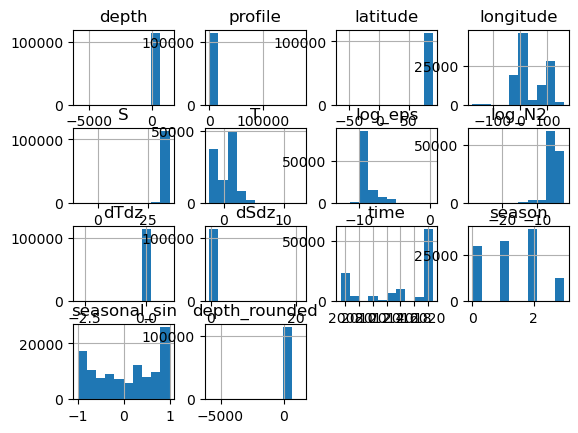

In [13]:
hist = df.hist(bins=10)

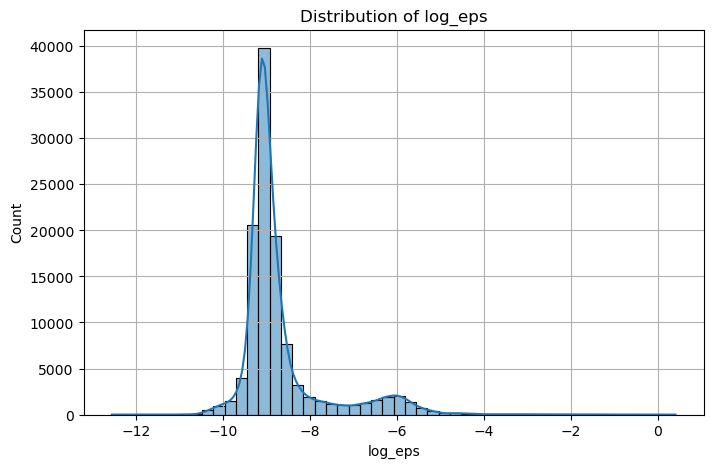

Mean: -8.696001702011108
Median: -9.012893312721982
Standard Deviation: 0.9952482261406205
Min: -12.56578254699707
Max: 0.4047824189666426
Skewness: 2.3264639302232077
Kurtosis: 6.228676465087021
10th percentile: -9.349059254684011
90th percentile: -7.222668561574938


In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['log_eps'], bins=50, kde=True)
plt.title('Distribution of log_eps')
plt.xlabel('log_eps')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# plot basic statistcs
print("Mean:", df['log_eps'].mean())
print("Median:", df['log_eps'].median())
print("Standard Deviation:", df['log_eps'].std())
print("Min:", df['log_eps'].min())
print("Max:", df['log_eps'].max())
print("Skewness:", df['log_eps'].skew())
print("Kurtosis:", df['log_eps'].kurtosis())

# Percentiles
print("10th percentile:", np.percentile(df['log_eps'], 10))
print("90th percentile:", np.percentile(df['log_eps'], 90))

# Split
First attempt with class imbalance

In [ ]:
#xstringlist = ['S','T','lat','hab','z','dSdz','dTdz','log_N2_sort']
xstringlist = ['S','T','latitude','dSdz','dTdz', 'log_N2']
ystringlist = ['log_eps']

# Combat data leakage
# Split datasets with unique profiles
profiles = df['profile'].unique()

profiles_train, profiles_temp = train_test_split(
    profiles, test_size=0.4, random_state=SEED)

profiles_val, profiles_test = train_test_split(
    profiles_temp, test_size=0.5, random_state=SEED)

# select rows where profile is in the corresponding set
train_df = df[df['profile'].isin(profiles_train)]
val_df = df[df['profile'].isin(profiles_val)]
test_df = df[df['profile'].isin(profiles_test)]

# select for variables
X_train = train_df[xstringlist]
y_train = train_df[ystringlist]

X_val = val_df[xstringlist]
y_val = val_df[ystringlist]

X_test = test_df[xstringlist]
y_test = test_df[ystringlist]

### Model configurations

In [ ]:
activ = 'tanh'#'softsign'#
opt='Adam'
pat=30
n_epochs = 1000
val_split=.15
dropout_fraction=.2
n_units1 =35
n_units2 =35
# n_units3 =n_unit

batch_size = 16

### Define model

In [10]:
def PermaDropout(rate):
    return Lambda(lambda x: K.dropout(x, level=rate))

# number of input variables
n_var_in = X_train.shape[1]

regr = MLPRegressor(random_state=1, max_iter=100).fit(X_train, y_train)

In [ ]:
y_pred = regr.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['log_eps']) 

u = ((y_test - y_pred) ** 2).sum()
v = ((y_test - y_test.mean()) ** 2).sum()
score = 1 - (u/v)
print("R2 prediction score is:", score)

print("MSE:", mean_squared_error(y_test, y_pred))

print("MAE:", mean_absolute_error(y_test, y_pred))

R2 prediction score is: log_eps    0.57851
dtype: float64
MSE: 0.2959589734748027
MAE: 0.33742917392055083


NOTE: R2 score is negative, caution for non-linear regression...
R2 is defined on the fact that the total number of squares (total variation in data) of a fitted model is equal to explained sum of squares (variation in fitted model) plus residual sum of squares (variation not explained by fitted model).

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$ ($Eq_1$)

So, negative $R^2$ if residual sum of squares exceeds total number of squares. This is mathematically impossible, thus it means that $Eq_1$ does not hold true, so total number of squares is no longer the sum.

Reason for this could be that SS_tot is calculated using just the data, whereas SS_res depends on model predictions and the data. So eq1 holds for models trained on the same data, not for using test_data.

# Deal with class imbalance of epsilon

In [5]:
(df_train_scaled_range, df_val_scaled_range, df_test_scaled_range,
 y_train_transformed, y_val_transformed, y_test_transformed
) = process_dataframe()

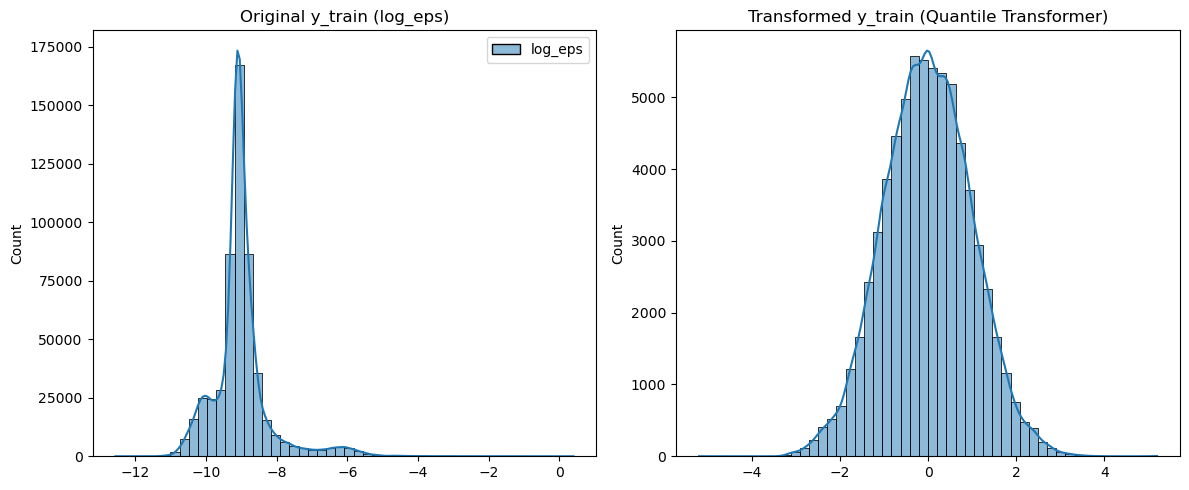

In [11]:
# Plot distribution before and after transformation
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(y_train, bins=50, kde=True)
plt.title('Original y_train (log_eps)')

plt.subplot(1, 2, 2)
sns.histplot(y_train_transformed.flatten(), bins=50, kde=True)
plt.title('Transformed y_train (Quantile Transformer)')

plt.tight_layout()
plt.show()

R² prediction score: 0.6821
MSE: 0.3187
MAE: 0.3272


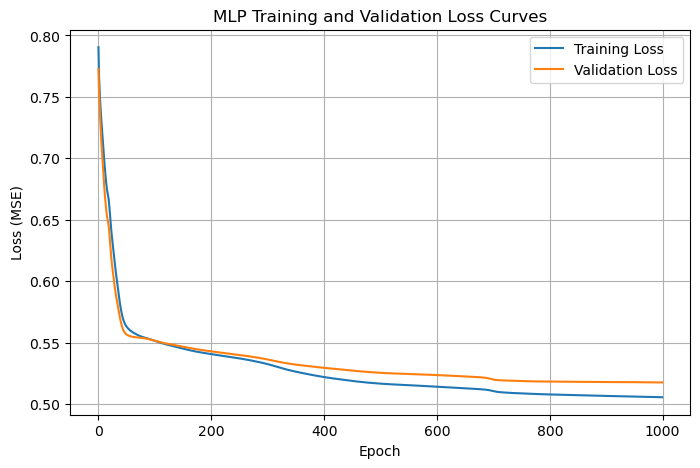

In [ ]:
def train_and_evaluate_mlp(df, x_features, y_features, seed=42):
    # split profiles
    profiles = df['profile'].unique()
    profiles_train, profiles_temp = train_test_split(profiles, test_size=0.4, random_state=seed)
    profiles_val, profiles_test = train_test_split(profiles_temp, test_size=0.5, random_state=seed)

    train_df = df[df['profile'].isin(profiles_train)]
    val_df = df[df['profile'].isin(profiles_val)]
    test_df = df[df['profile'].isin(profiles_test)]

    X_train, y_train = train_df[x_features], train_df[y_features]
    X_val, y_val = val_df[x_features], val_df[y_features]
    X_test, y_test = test_df[x_features], test_df[y_features]

    # log_eps is heavily left-skewed so we transform to a Gaussian
    qt = QuantileTransformer(output_distribution='normal', random_state=seed)
    y_train_transformed = qt.fit_transform(y_train)
    y_val_transformed = qt.transform(y_val)
    y_test_transformed = qt.transform(y_test)

    # Feature scaling
    scaler_range = MinMaxScaler()
    scaler_range.fit(X_train)

    X_train_scaled = pd.DataFrame(scaler_range.transform(X_train), columns=X_train.columns)
    X_val_scaled = pd.DataFrame(scaler_range.transform(X_val), columns=X_val.columns)
    X_test_scaled = pd.DataFrame(scaler_range.transform(X_test), columns=X_test.columns)

    # MLP hyperparameters
    activ = 'tanh'
    opt = 'adam'
    pat = 30
    n_epochs = 1000
    n_units1 = 35
    n_units2 = 35
    batch_size = 16

    # Build model
    regr = MLPRegressor(hidden_layer_sizes=(n_units1, n_units2),
                        activation=activ,
                        solver=opt,
                        max_iter=1, # single epoch
                        warm_start=True,
                        random_state=seed)

    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    patience_counter = 0

    for epoch in range(n_epochs):
        regr.fit(X_train_scaled, y_train_transformed)

        # training loss (mean squared error on training set)
        y_train_pred = regr.predict(X_train_scaled)
        train_loss = mean_squared_error(y_train_transformed, y_train_pred)

        # Validation loss
        y_val_pred = regr.predict(X_val_scaled)
        val_loss = mean_squared_error(y_val_transformed, y_val_pred)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # stop if no improvement in the loss function
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= pat:
            print(f"Early stopping at epoch {epoch+1}")
            break

    y_pred_transformed = regr.predict(X_test_scaled).reshape(-1, 1)
    y_pred = pd.DataFrame(qt.inverse_transform(y_pred_transformed), columns=['log_eps'])

    # R2 is leading score
    u = ((y_test.values.flatten() - y_pred['log_eps'].values.flatten()) ** 2).sum()
    v = ((y_test.values.flatten() - y_test.values.flatten().mean()) ** 2).sum()
    r2_score_val = 1 - (u/v)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"R² prediction score: {r2_score_val:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('MLP Training and Validation Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return regr, scaler_range, qt

model, feature_scaler, target_transformer = train_and_evaluate_mlp(df, xstringlist, ystringlist)

The training and validation loss curves both decrease steadily without diverging, indicating that the model is not overfitting.
Validation loss stays close to training loss throughout training, suggesting good generalization to unseen data.

After around 600–700 epochs, the losses flatten, meaning the model has nearly converged.

Overall, the model shows stable learning behavior and reaches a good balance between bias and variance.

#### Hyperparameter tuning

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

In [ ]:
param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.0001, 0.05],
          'learning_rate': ['constant','adaptive'],
          'solver': ['adam']}

gsc = GridSearchCV(
    regr,
    param_grid,
    cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)

best_params = grid_result.best_params_

best_mlp = MLPRegressor(hidden_layer_sizes = best_params["hidden_layer_sizes"], 
                        activation =best_params["activation"],
                        solver=best_params["solver"],
                        max_iter= 5000, n_iter_no_change = 200
              )

scoring = {
           'abs_error': 'neg_mean_absolute_error',
           'squared_error': 'neg_mean_squared_error',
           'r2':'r2'}

scores = cross_validate(best_mlp, X_train, y_train, cv=10, scoring=scoring,
                        return_train_score=True, return_estimator = True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# convert scores to DataFrame
scores_df = pd.DataFrame(scores)

# Create boxplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['abs_error', 'squared_error', 'r2']

for i, metric in enumerate(metrics):
    sns.boxplot(data=scores_df[[f'test_{metric}', f'train_{metric}']], ax=axs[i])
    axs[i].set_title(f'{metric.upper()} across folds')
    axs[i].set_ylabel(metric)
    axs[i].set_xticklabels(['Test', 'Train'])

plt.tight_layout()
plt.show()